# 予備実験

## 発話分類

In [1]:
%load_ext tensorboard
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import datetime

## データセット

In [3]:
train_dataset_path = "../Switchboard-Corpus/swda_data/train_set.txt"
test_dataset_path = "../Switchboard-Corpus/swda_data/test_set.txt"
val_dataset_path = "../Switchboard-Corpus/swda_data/val_set.txt"

In [4]:
train_dataset = []
f = open(train_dataset_path, "r", encoding='utf-8')
for row in f:
    train_dataset.append(row.strip())
f.close()

In [5]:
val_dataset = []
f = open(val_dataset_path, "r", encoding='utf-8')
for row in f:
    val_dataset.append(row.strip())
f.close()

In [6]:
test_dataset = []
f = open(test_dataset_path, "r", encoding='utf-8')
for row in f:
    test_dataset.append(row.strip())
f.close()

### データセット分割

In [7]:
## 訓練データ
train_utter_user = []
train_utter = []
train_utter_label = []

## テストデータ
test_utter_user = []
test_utter = []
test_utter_label = []

## 検証データ
val_utter_user = []
val_utter = []
val_utter_label = []

In [8]:
for j in train_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            train_utter_user.append(v)
        elif i==1:
            train_utter.append(v)
        else:
            train_utter_label.append(v)
            
print("finish")

finish


In [9]:
for j in test_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            test_utter_user.append(v)
        elif i==1:
            test_utter.append(v)
        else:
            test_utter_label.append(v)
            
print("finish")

finish


In [10]:
for j in val_dataset:
    for i,v in enumerate(j.split("|")):
        if i == 0:
            val_utter_user.append(v)
        elif i==1:
            val_utter.append(v)
        else:
            val_utter_label.append(v)
            
print("finish")

finish


### ラベルデータ数値化

In [11]:
label_path = "../Switchboard-Corpus/swda_data/metadata/labels.txt"
labels = []
f = open(label_path, "r", encoding='utf-8')
for row in f:
    labels.append(row.strip())
f.close()

In [12]:
label = {}
for i,v in enumerate(labels):
    label[v] = i

In [13]:
train_utter_labels = []
for i in train_utter_label:
    train_utter_labels.append(label[i])

In [14]:
test_utter_labels = []
for i in test_utter_label:
    test_utter_labels.append(label[i])

In [15]:
val_utter_labels = []
for i in val_utter_label:
    val_utter_labels.append(label[i])

## データセットをtensorflowに扱える形にする

In [16]:
train_data = tf.data.Dataset.from_tensor_slices((train_utter, train_utter_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_utter, test_utter_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_utter, val_utter_labels))
#test_data = tf.data.Dataset.from_tensor_slices((test_utter))

In [18]:
for i,v in train_data.take(10):
    print(i,v)

tf.Tensor(b'Okay.', shape=(), dtype=string) tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(b'So, What kind of experience do you, do you have, then with child care?', shape=(), dtype=string) tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(b'I guess, I think, uh, I wonder if that worked.', shape=(), dtype=string) tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(b'Does it say something?', shape=(), dtype=string) tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(b'I think it usually does.', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(b'You might try, uh,', shape=(), dtype=string) tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(b"I don't know,", shape=(), dtype=string) tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(b'hold it down a little longer,', shape=(), dtype=string) tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(b'and see if it, uh,', shape=(), dtype=string) tf.Tensor(19, shape=(), dtype=int32)
tf.Tensor(b'Okay', shape=(), dtype=string) tf.Tensor(4, shape=(), dtype=in

In [19]:
i,v = next(iter(train_data))
print(i,v)

tf.Tensor(b'Okay.', shape=(), dtype=string) tf.Tensor(17, shape=(), dtype=int32)


## トークナイザー

In [18]:
## ボキャブラリーリスト
vocabulary_set = set()
## トークナイザー
tokenizer = tfds.features.text.Tokenizer()

## 分かち書き
for text_tensor,_ in train_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    #print(some_tokens)
    vocabulary_set.update(some_tokens)
    
## ボキャブラリーリスト作成
vocab_size = len(vocabulary_set)

## encode生成

In [19]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [20]:
def encode(token, label):
    token = encoder.encode(token.numpy())
    return token, label

@tf.function
def tf_encoder(utter, label):
    encoded_text, label = tf.py_function(encode,[utter, label],[tf.int64, tf.int32])
    encoded_text.set_shape([None])
    label.set_shape([])
    return encoded_text, label

## テストデータ

In [137]:
def test_encode(token):
    token = encoder.encode(token.numpy())
    return token

@tf.function
def test_tf_encoder(utter):
    encoded_text = tf.py_function(encode,[utter],[tf.int64])
    #encoded_text.set_shape([None])
    
    return encoded_text


## metrics

In [69]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

## データ設計

In [21]:
max_len = 40

In [22]:
all_train_data_encode = train_data.map(tf_encoder)
all_test_data_encode = test_data.map(tf_encoder)
all_val_data_encode = val_data.map(tf_encoder)

In [23]:
utter_train_data = all_train_data_encode.padded_batch(64, padded_shapes=([None], []), drop_remainder=True)
utter_test_data = all_test_data_encode.padded_batch(64, padded_shapes=([None], []), drop_remainder=True)
utter_val_data = all_val_data_encode.padded_batch(64, padded_shapes=([None], []), drop_remainder=True)

In [148]:
for i,v in utter_test_data.take(10):
    print(i,v)

tf.Tensor(
[[13492 19133     0 ...     0     0     0]
 [21587  2343  2191 ...     0     0     0]
 [11719  8328 17129 ...     0     0     0]
 ...
 [  316     0     0 ...     0     0     0]
 [20545 20106 20545 ...     0     0     0]
 [  316     0     0 ...     0     0     0]], shape=(64, 58), dtype=int64) tf.Tensor(
[17  9 24  2 22  0  0  2  1  6 10  0  0 11  6 22  3  0  1  0  0  0  1  0
  0  0  1  0  0  0  0  0  0  0  0  0  1  2  0  0  1 16  7  7  0  0  3  2
  0  1  2  2  0  0  1 14  7  0  0  1  5  1  2  1], shape=(64,), dtype=int32)
tf.Tensor(
[[  164 19685  1925 ...     0     0     0]
 [ 4907  4171     0 ...     0     0     0]
 [16190  4110  5521 ...     0     0     0]
 ...
 [ 8025     0     0 ...     0     0     0]
 [21321  2792 20545 ...     0     0     0]
 [20545 20106 10585 ...     0     0     0]], shape=(64, 45), dtype=int64) tf.Tensor(
[ 2  1  0  0  1  1  0  1  1  1  0  2  4  2 22  3  0 13 18  3  0  3 21  1
  0  0  3 12  4  4  6  0  1  0  0  1  0  0  0  1  0  0  0  1  5  2  2  1

In [27]:
utter_train_data, utter_test_data, utter_val_data

(<PaddedBatchDataset shapes: ((64, None), (64,)), types: (tf.int64, tf.int32)>,
 <PaddedBatchDataset shapes: ((64, None), (64,)), types: (tf.int64, tf.int32)>,
 <PaddedBatchDataset shapes: ((64, None), (64,)), types: (tf.int64, tf.int32)>)

## モデル設計(RNN)

In [28]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [29]:
rnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history = rnn_model.fit(utter_train_data, epochs=10,
                    validation_data=utter_val_data, 
                    validation_steps=30)

Epoch 1/10
3006/3006 [==============================] - 211s 70ms/step - loss: -171.0589 - accuracy: 0.1976 - val_loss: -309.1272 - val_accuracy: 0.1766
Epoch 2/10
3006/3006 [==============================] - 216s 72ms/step - loss: -879.7972 - accuracy: 0.1982 - val_loss: -1072.3658 - val_accuracy: 0.1755
Epoch 3/10
3006/3006 [==============================] - 250s 83ms/step - loss: -2049.8381 - accuracy: 0.1921 - val_loss: -2051.0625 - val_accuracy: 0.1755
Epoch 4/10
3006/3006 [==============================] - 220s 73ms/step - loss: -3771.5759 - accuracy: 0.1921 - val_loss: -3312.4087 - val_accuracy: 0.1755
Epoch 5/10
3006/3006 [==============================] - 214s 71ms/step - loss: -5987.7651 - accuracy: 0.1921 - val_loss: -5530.4316 - val_accuracy: 0.1755
Epoch 6/10
3006/3006 [==============================] - 215s 72ms/step - loss: -8015.5977 - accuracy: 0.1921 - val_loss: -6451.9243 - val_accuracy: 0.1755
Epoch 7/10
3006/3006 [==============================] - 207s 69ms/step - 

## 可視化

In [24]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

## TensorBoard 可視化

In [152]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### acc

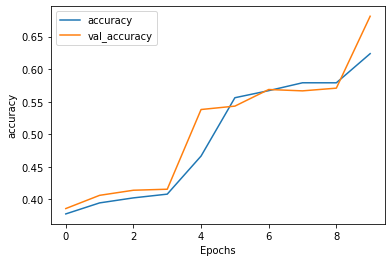

In [166]:
plot_graphs(history, 'accuracy')

### loss

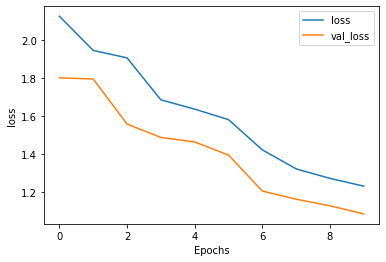

In [167]:
plot_graphs(history, 'loss')

## モデル(LSTM)

In [25]:
BATCH_SIZE = 64

In [26]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 128)(X)
lstm = tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(embedded)
fully_connected = tf.keras.layers.Dense(units=256, activation='relu')(lstm)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)
Rnn_Model = tf.keras.Model(inputs=X, outputs=Y)

Rnn_Model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

In [27]:
Rnn_Model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, None)]              0         
_________________________________________________________________
embedding (Embedding)        (64, None, 128)           2797312   
_________________________________________________________________
lstm (LSTM)                  (64, 128)                 131584    
_________________________________________________________________
dense (Dense)                (64, 256)                 33024     
_________________________________________________________________
final_layer (Dense)          (64, 41)                  10537     
Total params: 2,972,457
Trainable params: 2,972,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = Rnn_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30)

Epoch 1/5
3006/3006 [==============================] - 555s 185ms/step - loss: 2.1355 - accuracy: 0.3776 - val_loss: 1.8957 - val_accuracy: 0.3760
Epoch 2/5
3006/3006 [==============================] - 603s 201ms/step - loss: 1.7352 - accuracy: 0.4221 - val_loss: 1.2599 - val_accuracy: 0.5870
Epoch 3/5
3006/3006 [==============================] - 522s 174ms/step - loss: 1.2926 - accuracy: 0.6083 - val_loss: 1.0871 - val_accuracy: 0.6146
Epoch 4/5
3006/3006 [==============================] - 563s 187ms/step - loss: 1.1837 - accuracy: 0.6378 - val_loss: 1.0391 - val_accuracy: 0.6760
Epoch 5/5
2088/3006 [===================>..........] - ETA: 3:10 - loss: 1.1431 - accuracy: 0.6519

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

## モデル(双方向RNN)

In [230]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 128)(X)
lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4))(embedded)
fully_connected = tf.keras.layers.Dense(units=256, activation='relu')(lstm)
Y = tf.keras.layers.Dense(41, activation='sigmoid',
                          name='final_layer')(fully_connected)
Bidirectional_Rnn_Model = tf.keras.Model(inputs=X, outputs=Y)

Bidirectional_Rnn_Model.compile(loss='sparse_categorical_crossentropy',
                                optimizer=tf.keras.optimizers.Adam(1e-4),
                                metrics=['acc'])

In [231]:
Bidirectional_Rnn_Model.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(64, None)]              0         
_________________________________________________________________
embedding_20 (Embedding)     (64, None, 128)           2797312   
_________________________________________________________________
bidirectional_12 (Bidirectio (64, 256)                 263168    
_________________________________________________________________
dense_47 (Dense)             (64, 256)                 65792     
_________________________________________________________________
final_layer (Dense)          (64, 41)                  10537     
Total params: 3,136,809
Trainable params: 3,136,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Bidirectional_history = Bidirectional_Rnn_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[tensorboard_callback])

Epoch 1/5
3006/3006 [==============================] - 929s 309ms/step - loss: 1.2228 - acc: 0.6349 - val_loss: 0.9821 - val_acc: 0.7026
Epoch 2/5
3006/3006 [==============================] - 1135s 378ms/step - loss: 1.0892 - acc: 0.6786 - val_loss: 0.9053 - val_acc: 0.7323
Epoch 3/5
3006/3006 [==============================] - 885s 294ms/step - loss: 1.0096 - acc: 0.6983 - val_loss: 0.8562 - val_acc: 0.7417
Epoch 4/5
3006/3006 [==============================] - 923s 307ms/step - loss: 0.9574 - acc: 0.7123 - val_loss: 0.8377 - val_acc: 0.7469
Epoch 5/5
1849/3006 [=================>............] - ETA: 5:52 - loss: 0.9343 - acc: 0.7162

In [ ]:
plot_graphs(Bidirectional_history, 'acc')

In [ ]:
plot_graphs(Bidirectional_history, 'loss')

## モデル(Attention + 順方向RNN)

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [165]:
from keras_self_attention import SeqSelfAttention

In [221]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 64)(X)
lstm, forward_h, forward_c = tf.keras.layers.LSTM(128,
                                                return_sequences=True,
                                                return_state=True, 
                                                dropout=0.4, 
                                                recurrent_dropout=0.4)(embedded)
#state_h = tf.keras.layers.Concatenate()([forward_h, backward_h]) # 重みを結合
context,attention_weights = Attention(64)(lstm,forward_h) # ここにAttentionレイヤを挟む
fully_connected = tf.keras.layers.Dense(units=128, activation='relu')(context)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)

Attention_Model = tf.keras.Model(inputs=X, outputs=Y)

Attention_Model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])

In [222]:
Attention_Model.summary()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(64, None)]         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (64, None, 64)       1398656     input_16[0][0]                   
__________________________________________________________________________________________________
lstm_15 (LSTM)                  [(64, None, 128), (N 98816       embedding_17[0][0]               
__________________________________________________________________________________________________
attention_8 (Attention)         ((64, 128), (64, Non 16577       lstm_15[0][0]                    
                                                                 lstm_15[0][1]        

In [223]:
Attention_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[tensorboard_callback])

Epoch 1/5
3006/3006 [==============================] - 457s 152ms/step - loss: 2.0822 - acc: 0.3790 - val_loss: 1.4909 - val_acc: 0.3771
Epoch 2/5
3006/3006 [==============================] - 19259s 6s/step - loss: 1.4189 - acc: 0.5852 - val_loss: 1.1828 - val_acc: 0.5958
Epoch 3/5
3006/3006 [==============================] - 424s 141ms/step - loss: 1.2924 - acc: 0.6153 - val_loss: 1.1010 - val_acc: 0.6448
Epoch 4/5
3006/3006 [==============================] - 459s 153ms/step - loss: 1.2157 - acc: 0.6344 - val_loss: 1.0604 - val_acc: 0.6734
Epoch 5/5
3006/3006 [==============================] - 423s 141ms/step - loss: 1.1707 - acc: 0.6458 - val_loss: 1.0325 - val_acc: 0.6745


## モデル(Attention + 双方向RNN)

In [121]:
X = tf.keras.Input(shape=(None,), batch_size=BATCH_SIZE)
embedded = tf.keras.layers.Embedding(encoder.vocab_size, 64)(X)
lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(
                                                        tf.keras.layers.LSTM(128,
                                                                             return_sequences=True,
                                                                             return_state=True,
                                                                             dropout=0.4, 
                                                                             recurrent_dropout=0.4))(embedded)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h]) # 重みを結合
context,attention_weights = Attention(64)(lstm,state_h) # ここにAttentionレイヤを挟む
fully_connected = tf.keras.layers.Dense(units=128, activation='relu')(context)
Y = tf.keras.layers.Dense(41, activation='sigmoid',name='final_layer')(fully_connected)

Bidirectional_Attention_Model = tf.keras.Model(inputs=X, outputs=Y)

Bidirectional_Attention_Model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['acc'])

In [209]:
Bidirectional_Attention_Model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(64, None)]         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (64, None, 64)       1398656     input_11[0][0]                   
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) [(64, None, 256), (N 197632      embedding_11[0][0]               
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256)          0           bidirectional_7[0][1]            
                                                                 bidirectional_7[0][3]

In [163]:
Bidirectional_Attention_Model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[tensorboard_callback])

Epoch 1/5
3006/3006 [==============================] - 700s 233ms/step - loss: 1.3479 - acc: 0.6029 - val_loss: 1.1791 - val_acc: 0.5943
Epoch 2/5
3006/3006 [==============================] - 860s 286ms/step - loss: 1.2637 - acc: 0.6106 - val_loss: 1.0910 - val_acc: 0.6031
Epoch 3/5
3006/3006 [==============================] - 734s 244ms/step - loss: 1.2068 - acc: 0.6152 - val_loss: 1.0744 - val_acc: 0.5964
Epoch 4/5
3006/3006 [==============================] - 824s 274ms/step - loss: 1.2044 - acc: 0.6162 - val_loss: 1.0622 - val_acc: 0.6219
Epoch 5/5
3006/3006 [==============================] - 28529s 9s/step - loss: 1.1560 - acc: 0.6432 - val_loss: 1.0225 - val_acc: 0.6849


In [ ]:
plot_graphs(Bidirectional_Attention_Model, 'accuracy')

In [ ]:
plot_graphs(Bidirectional_Attention_Model, 'loss')

## モデル ver2

In [210]:
from keras_self_attention import SeqSelfAttention

In [216]:
self_attetntion_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(64,)),
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    SeqSelfAttention(attention_activation='sigmoid'),
    tf.keras.layers.Dense(units=41)
])

In [217]:
self_attetntion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

In [218]:
self_attetntion_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 64, 64)            1398656   
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 64)          4161      
_________________________________________________________________
dense_40 (Dense)             (None, None, 41)          2665      
Total params: 1,405,482
Trainable params: 1,405,482
Non-trainable params: 0
_________________________________________________________________


In [219]:
self_attetntion_model.fit(utter_train_data, epochs=5,
                    validation_data=utter_val_data, 
                    validation_steps=30,
                   callbacks=[tensorboard_callback])

Epoch 1/5


ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (64, 1) and (64, 64, 41) are incompatible


## 注意単語の可視化

In [164]:
attention_with_w_model = tf.keras.Model(inputs=Attention_Model.input, 
                               outputs=[Attention_Model.output, 
                                Attention_Model.get_layer('attention_7').output])

In [ ]:
attention_with_w_model.